In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input\american_sign_language.png
./input\amer_sign2.png
./input\amer_sign3.png
./input\sign_mnist_test\sign_mnist_test.csv
./input\sign_mnist_train\sign_mnist_train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [3]:
train_df = pd.read_csv("input/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("input/sign_mnist_test/sign_mnist_test.csv")
test = pd.read_csv("input/sign_mnist_test/sign_mnist_test.csv")
y = test['label']

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


C:\ProgramData\Anaconda3\envs\chaewon\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

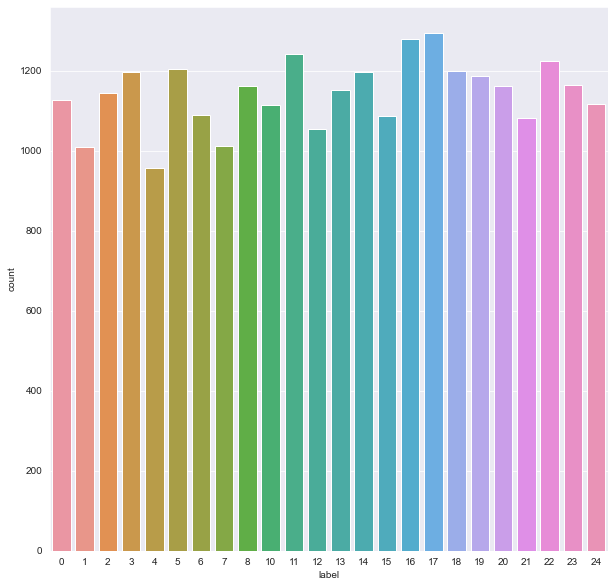

In [5]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

위 시각화는 데이터셋이 훈련하기에 충분히 균형적인 데이터셋임을 알려줍니다.

In [6]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']
y_train[:5]

0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64

In [7]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)
y_train[:5]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [8]:
x_train = train_df.values
x_test = test_df.values
x_train[:5]

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       [211, 211, 212, ..., 222, 229, 163],
       [164, 167, 170, ..., 163, 164, 179]], dtype=int64)

조명의 차이 효과를 줄이기 위해 그레이스케일 정규화를 수행.또한 CNN은 [0.1] 데이터에서 [0.255]보다 더 빨리 수렴

In [9]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255
x_train[:5]

array([[0.41960784, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607843,
        0.79215686],
       [0.60784314, 0.61568627, 0.61176471, ..., 0.40392157, 0.52941176,
        0.58431373],
       [0.73333333, 0.7372549 , 0.7372549 , ..., 0.76470588, 0.76078431,
        0.76470588],
       [0.82745098, 0.82745098, 0.83137255, ..., 0.87058824, 0.89803922,
        0.63921569],
       [0.64313725, 0.65490196, 0.66666667, ..., 0.63921569, 0.64313725,
        0.70196078]])

In [40]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

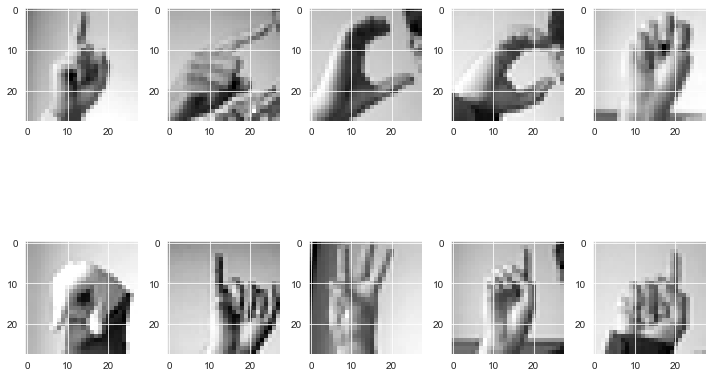

In [41]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

정규화된 이미지

In [42]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

overfitting 문제를 피하기 위해 데이터 세트를 인위적으로 확장

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [44]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)         

In [45]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , 
                    validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 98s 457ms/step - loss: 1.1129 - accuracy: 0.6553 - val_loss: 3.1263 - val_accuracy: 0.0887
Epoch 2/20
215/215 [==============================] - 97s 453ms/step - loss: 0.2157 - accuracy: 0.9290 - val_loss: 1.8105 - val_accuracy: 0.4583
Epoch 3/20
215/215 [==============================] - 96s 449ms/step - loss: 0.0999 - accuracy: 0.9676 - val_loss: 0.0986 - val_accuracy: 0.9677
Epoch 4/20
215/215 [==============================] - 104s 485ms/step - loss: 0.0612 - accuracy: 0.9801 - val_loss: 0.0468 - val_accuracy: 0.9854
Epoch 5/20
215/215 [==============================] - 107s 496ms/step - loss: 0.0442 - accuracy: 0.9860 - val_loss: 0.0886 - val_accuracy: 0.9728
Epoch 6/20
215/215 [==============================] - 99s 462ms/step - loss: 0.0343 - accuracy: 0.9891 - val_loss: 0.0060 - val_accuracy: 0.9992
Epoch 7/20
215/215 [==============================] - 101s 469ms/step - loss: 0.0309 - accuracy: 0.9899 - val_loss: 0.1831 - val

In [46]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 15ms/step - loss: 4.7730e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


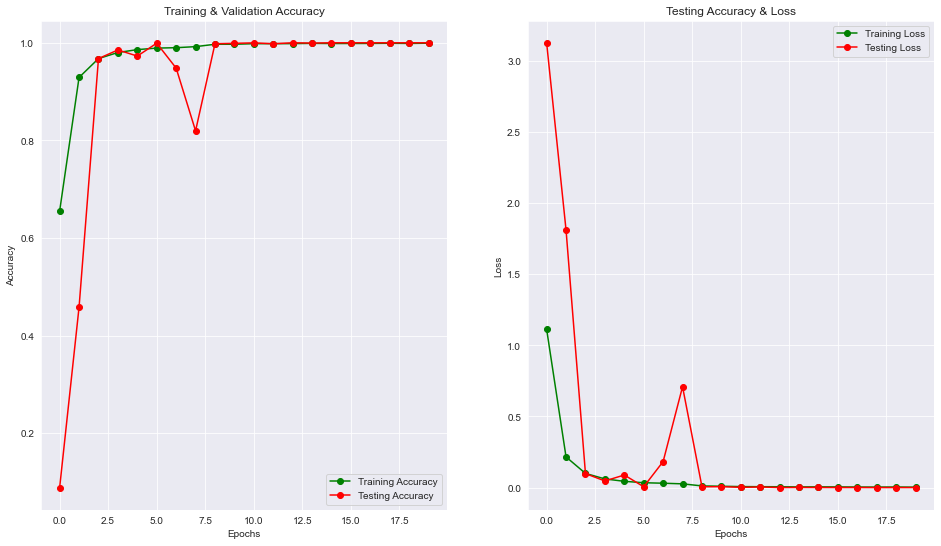

In [47]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [58]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

array([ 6,  5, 10,  0,  3], dtype=int64)

In [59]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [60]:
cm = confusion_matrix(y,predictions)

In [61]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , 
                  columns = [i for i in range(25) if i != 9])

<AxesSubplot:>

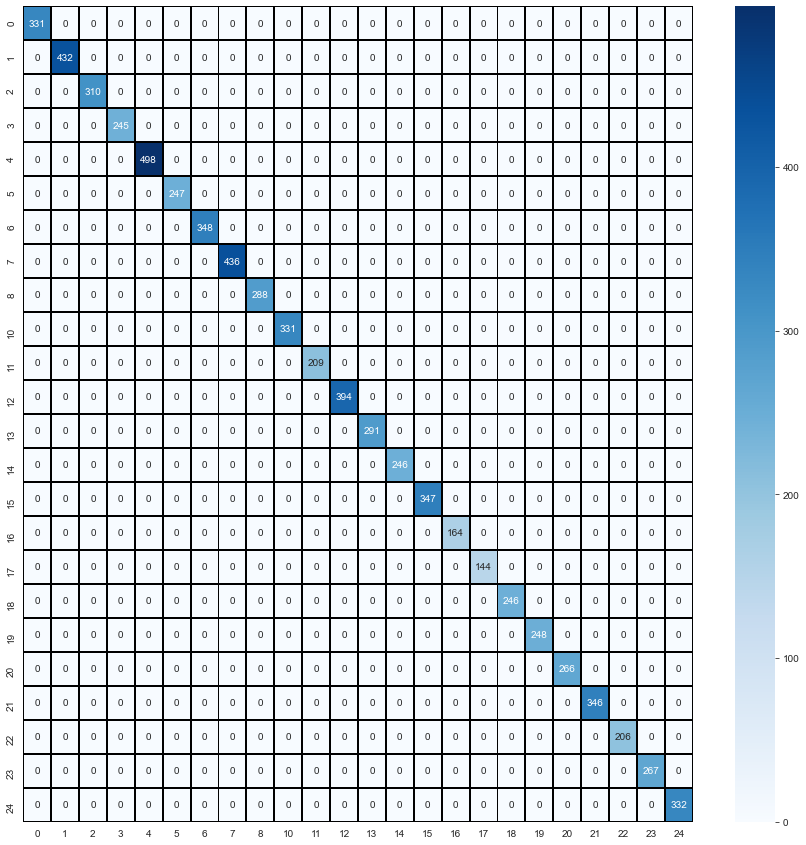

In [62]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')